In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException, ElementClickInterceptedException

sns.set_style('darkgrid')

In [2]:
columns = ['Note_ID', 'Grade', 'Rate_%', 'Effective_Rate_%', 'Term', 'PD_%', 'Funding', 'Funded_%']
df = pd.DataFrame(None,columns = columns)

# Web Scraping

Let's begin scraping all of the available loan data and whilst we are gathering the data, also conduct some basic string / text manipulation to get the loan data into a desirable DataFrame format.

In [3]:
url = 'https://p2p.fundaztic.com/loaninfo/openHistoryLoan.htm'
driver = webdriver.Chrome('/Users/weeliptan/Desktop/chromedriver')
driver.get(url)
time.sleep(5)

i = 0
while True:
    table_elements = driver.find_elements_by_xpath("//*[@id='loaninfotr']")
    for element in table_elements:
        word_list = element.text.split()
        word_list[3] = word_list[3].replace('%','')
        word_list[-1] = word_list[-1].replace('%','')
        word_list[1] = word_list[1] + word_list[2]
        word_list.pop(2), word_list.pop(5)
        array = np.array(word_list)
        word_list_df = pd.DataFrame(array.reshape(1,-1), columns = df.columns)
        df = df.append(word_list_df, ignore_index=True)

    try:
        next_link = driver.find_elements_by_xpath("//*[@id='bot_next_page']")
        next_link[-1].click()
        i += 1
        print ('Pages scrapped:', i)
        time.sleep(2)

    except (NoSuchElementException, StaleElementReferenceException, ElementClickInterceptedException):
        i += 1
        print ('Pages scrapped:', i)
        print ('Completed')
        break

driver.quit()

Pages scrapped: 1
Pages scrapped: 2
Pages scrapped: 3
Pages scrapped: 4
Pages scrapped: 5
Pages scrapped: 6
Pages scrapped: 7
Pages scrapped: 8
Pages scrapped: 9
Pages scrapped: 10
Pages scrapped: 11
Pages scrapped: 12
Pages scrapped: 13
Pages scrapped: 14
Pages scrapped: 15
Pages scrapped: 16
Pages scrapped: 17
Pages scrapped: 18
Pages scrapped: 19
Pages scrapped: 20
Pages scrapped: 21
Pages scrapped: 22
Pages scrapped: 23
Pages scrapped: 24
Pages scrapped: 25
Pages scrapped: 26
Pages scrapped: 27
Pages scrapped: 28
Pages scrapped: 29
Pages scrapped: 30
Pages scrapped: 31
Pages scrapped: 32
Pages scrapped: 33
Pages scrapped: 34
Pages scrapped: 35
Pages scrapped: 36
Pages scrapped: 37
Pages scrapped: 38
Pages scrapped: 39
Pages scrapped: 40
Pages scrapped: 41
Pages scrapped: 42
Pages scrapped: 43
Pages scrapped: 44
Pages scrapped: 45
Pages scrapped: 46
Pages scrapped: 47
Pages scrapped: 48
Pages scrapped: 49
Pages scrapped: 50
Pages scrapped: 51
Pages scrapped: 52
Pages scrapped: 53
Pa

That took a while. Let's save this into a csv for future use.

In [4]:
df.to_csv('Latest_Scrapped_P2P_Notes.csv')

# Data cleaning, pre-processing and EDA

Examine the shape of the scrapped data and display the first 5 rows of data

In [5]:
df_summary = pd.read_csv('Latest_Scrapped_P2P_Notes.csv', index_col = 0)

display(df_summary.shape)
df_summary.head()

(970, 8)

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%
0,1118,D7,11.68,20.90,12,6.30,"20,000.00",100.0
1,1116,D8,13.28,23.72,24,9.25,"50,000.00",100.0
2,1115,D7,12.18,21.88,24,8.42,"30,000.00",100.0
3,1114,C6,12.08,21.33,36,4.69,"50,000.00",100.0
4,1113,C6,13.20,23.53,12,5.33,"55,000.00",100.0


Scraping the data worked as expected. Now we check the datatype of each column and for any missing values.

In [6]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 8 columns):
Note_ID             970 non-null int64
Grade               970 non-null object
Rate_%              970 non-null float64
Effective_Rate_%    970 non-null float64
Term                970 non-null int64
PD_%                970 non-null float64
Funding             970 non-null object
Funded_%            970 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 68.2+ KB


We need to fix the text number formatting ahead of converting it into float64.

In [7]:
df_summary.Funding = df_summary.Funding.apply(lambda x: x.replace(',', ''))
df_summary.Grade = df_summary.Grade.apply(lambda x: x[1])

Let's now convert non-float64 columns to float64 which will be required for future numerical tasks and modelling.

In [8]:
columns_to_convert = [col for col in df_summary.columns if col not in ['Rate_%','Effective_Rate_%', 'PD_%', 'Funded_%']] 
columns_to_convert

for i in columns_to_convert:
    df_summary[i] = df_summary[i].astype('float64')
    
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 8 columns):
Note_ID             970 non-null float64
Grade               970 non-null float64
Rate_%              970 non-null float64
Effective_Rate_%    970 non-null float64
Term                970 non-null float64
PD_%                970 non-null float64
Funding             970 non-null float64
Funded_%            970 non-null float64
dtypes: float64(8)
memory usage: 68.2 KB


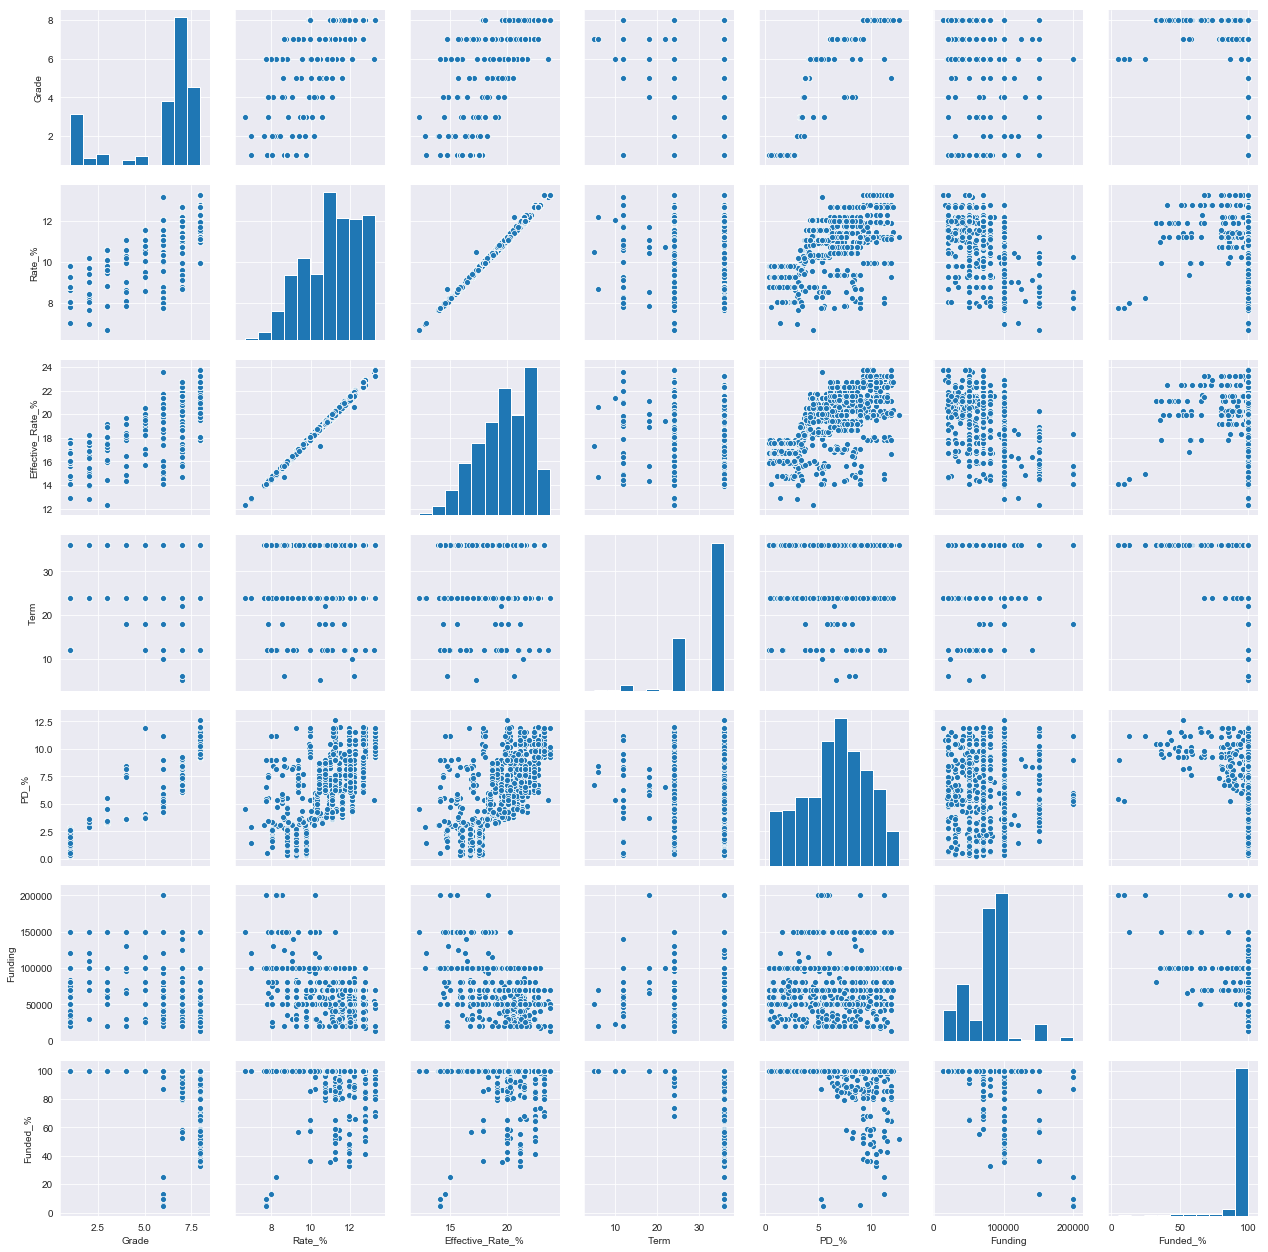

In [9]:
sns.pairplot(data = df_summary.iloc[:, 1:])
plt.show()

Just by glancing at the pairplot above, we can deduct that there are some form of linear relationship between our target variable here 'Rate_%' and other features here including the 'PD_%', 'Funding' and 'Term'. Just so we include only succesfully funded notes, let's exclude notes which were not succesfully disbursed (ie < 100%)

In [10]:
rows_to_drop = df_summary[df_summary['Funded_%'] < 100].index
df_summary.drop(rows_to_drop, axis = 0, inplace = True)

Cool, let's now split our data into X and Y. For X we drop:
 - Note_ID: this does not provide any predictive value
 - Funded_%: as we've now dropped anything below 100%, this would be removed as the variance is 0 and would not add much predictive power
 - Rate_%: this is our target variable
 - Effective_Rate_%: this is similar to the above but expressed in a different manner [taking into the effect of compounding on a periodic basis]. This can be confirmed referring back to the pairplots between Rate_% and Effective_Rate_%

In [11]:
X = df_summary.drop(['Note_ID', 'Funded_%', 'Rate_%', 'Effective_Rate_%'], axis = 1)
y = df_summary['Rate_%']

Now, let's generate a basic correlation matrix to identify any features that are highly correlated to each other. We then drop them to avoid any issues of multicollinearity in our regression model.

In [12]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Grade,Term,PD_%,Funding
Grade,1,0.0107931,0.893632,0.0456777
Term,0.0107931,1,0.0082445,0.0964226
PD_%,0.893632,0.0082445,1,0.0107624
Funding,0.0456777,0.0964226,0.0107624,1


No surprise that the PD_% (probability of default) correlates highly with the Grade. The higher the grade, the higher the PD_%. Let's drop the Grade feature then.

In [13]:
X = X.drop('Grade', axis = 1)

# Train Test Split 

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# 1. Regression Model

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr_base = LinearRegression()
lr_base.fit(X_train, y_train)
base_R2_score = round(lr_base.score(X_train, y_train), 4)
print ('Base R2 score of:', base_R2_score)

Base R2 score of: 0.5571


This does pretty poorly out of the box at 56% R2. Let's try exploring interaction terms.

In [16]:
X_interact_1 = X_train.copy()
X_interact_2 = X_train.copy()
X_interact_3 = X_train.copy()

X_interact_1['Term_PD_%'] = X_interact_1['Term'] * X_interact_1['PD_%']
X_interact_2['Term_Funding'] = X_interact_2['Term'] * X_interact_2['Funding']
X_interact_3['Funding_PD_%'] = X_interact_3['Funding'] * X_interact_3['PD_%']

models_to_evaluate = [X_interact_1, X_interact_2, X_interact_3]

for model in models_to_evaluate:
    interact = LinearRegression()
    interact.fit(model, y_train)
    interact_score = interact.score(model, y_train)
    print ('R2 of: {}'.format(round(interact_score, 4)))

R2 of: 0.5573
R2 of: 0.5571
R2 of: 0.5603


Looks like introducing interaction terms do not improve the model performance by a significant amount. Maybe polynomials will help? Let's take a look again at the scatter plots for each of our independent variables against the target feature.

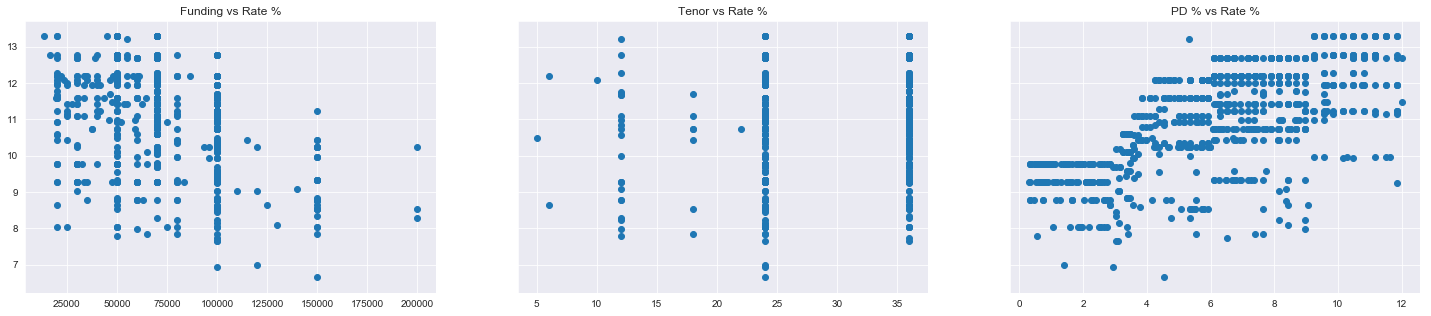

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 5), sharey = True)
ax1.scatter(df_summary['Funding'], df_summary['Rate_%'])
ax1.set_title('Funding vs Rate %')
ax2.scatter(df_summary['Term'], df_summary['Rate_%'])
ax2.set_title('Tenor vs Rate %')
ax3.scatter(df_summary['PD_%'], df_summary['Rate_%'])
ax3.set_title('PD % vs Rate %')
plt.show()

Just by looking at the scatterplots, it is fairly difficult to deduct if there are any non-linear relationships. There could possibly be some form of quadratic relationship for both the funding and PD_% features against the target variable. Let's introduce them and see if there are any improvements in the model's R2 scores.

In [18]:
X_train_poly_2 = X_train.copy()

X_train_poly_2['Funding2'] = X_train_poly_2['Funding'] ** 2
X_train_poly_2['PD2'] = X_train_poly_2['PD_%'] ** 2

poly = LinearRegression()
poly.fit(X_train_poly_2, y_train)
poly_R2_score = round(poly.score(X_train_poly_2, y_train), 4)

print ('Poly R2 score of:', poly_R2_score)

Poly R2 score of: 0.6142


Looks like there is a 5% improvement in our model just by introducing a quadratic relationship in two of the independent features. Now, let's also explore other types of regressor model out there to examine if we can improve upon the 61% obtained above.

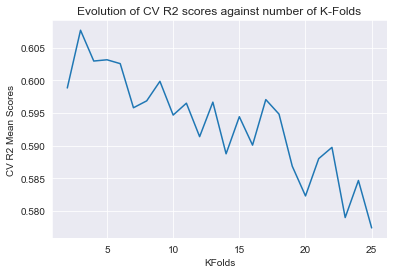

In [19]:
num_range = range(2,26)
cv_scores = []

for i in num_range:
    poly_cv = LinearRegression()
    cv_scores.append(np.mean(cross_val_score(poly_cv, X_train_poly_2, y_train, cv = i)))
    
plt.plot(num_range, cv_scores)
plt.ylabel('CV R2 Mean Scores')
plt.xlabel('KFolds')
plt.title('Evolution of CV R2 scores against number of K-Folds')
plt.show()

Let's run this through Statsmodel's OLS function to get a full summary of the model.

In [20]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

linreg_poly = OLS(y_train, add_constant(X_train_poly_2)).fit()
linreg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rate_%   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     213.0
Date:                Wed, 12 Feb 2020   Prob (F-statistic):          1.01e-135
Time:                        18:36:49   Log-Likelihood:                -844.93
No. Observations:                 675   AIC:                             1702.
Df Residuals:                     669   BIC:                             1729.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6853      0.238     32.264      0.000       7.218       8.153
Term           0.0351      0.005      6.993      0.000       0.025       0.045
PD_%           0.6363      0.044     14.534      0.000       0.550       0.722
Funding     6.968e-06   4.16e-06      1.676      0.094    -1.2e-06    1.51e-05
Funding2   -1.494e-10    2.4e-11     -6.214      0.000   -1.97e-10   -1.02e-10
PD2           -0.0275      0.004     -7.808      0.000      -0.034      -0.021
==============================================================================
Omnibus:                       54.712   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.203
Skew:                          -0.680   Prob(JB):                     9.39e-16
Kurtosis:                       3.783   Cond. No.                     6.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7],
                 'min_samples_leaf' : range(5,50,5),
                 'max_features': [1, 2, 3]}

rf_grid = RandomForestRegressor()
grid_rf = GridSearchCV(rf_grid, param_grid = params_grid, n_jobs = -1, verbose = True, cv = 10)
grid_rf.fit(X_train, y_train)

print (round(grid_rf.best_score_, 4))
print (grid_rf.best_params_)

Fitting 10 folds for each of 189 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   31.3s


0.6921
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 5}


[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   33.3s finished


100% |########################################################################|


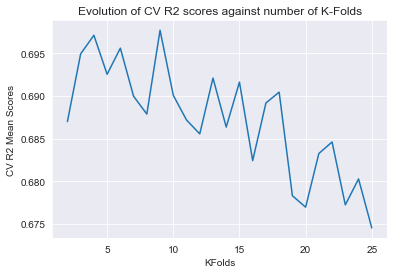

In [27]:
from progressbar import ProgressBar
pbar = ProgressBar()

num_range = range(2,26)
cv_scores_rf = []

for i in pbar(num_range):
    rf_regressor_cv = RandomForestRegressor(n_jobs=-1, max_depth = 7, max_features = 2, min_samples_leaf = 5)
    cv_scores_rf.append(np.mean(cross_val_score(rf_regressor_cv, X_train, y_train, cv = i)))
    
plt.plot(num_range, cv_scores_rf)
plt.ylabel('CV R2 Mean Scores')
plt.xlabel('KFolds')
plt.title('Evolution of CV R2 scores against number of K-Folds')
plt.show()

Nice, looks like we've improved R2 score by a fairl amount (ie 4%). Let's now test our chosen RF regressor model on the test dataset

In [28]:
rf_regressor_cv.fit(X_train, y_train)
predictions =  rf_regressor_cv.predict(X_test)
round(r2_score(y_test, predictions), 4)

0.6543

# Model Deployment

We can now deploy our model to guide future investments. For fun, let's apply this to the past investments and also specify a 50bps threshold (accept any investments which are priced 50bps above our model price)| 

In [29]:
def predict(x):
    subset = x[['Term', 'PD_%', 'Funding']].values.reshape(1, -1)
    prediction = rf_regressor_cv.predict(subset)
    return round(prediction[0], 2)

def invest_decision(x):
    if x['Delta_%'] >= 0.5:
        return 'Yes'
    else:
        return 'No'

In [30]:
df_summary['Predicted_Rate_%'] = df_summary.apply(predict, axis = 1)
df_summary['Delta_%'] = df_summary['Rate_%'] - df_summary['Predicted_Rate_%']
df_summary['Invest'] = df_summary.apply(invest_decision, axis = 1)

In [31]:
df_summary.head(5).drop(['Effective_Rate_%', 'Funded_%'], axis = 1)

,Note_ID,Grade,Rate_%,Term,PD_%,Funding,Predicted_Rate_%,Delta_%,Invest
0,1118.0,7.0,11.68,12.0,6.30,20000.0,11.03,0.65,Yes
1,1116.0,8.0,13.28,24.0,9.25,50000.0,11.78,1.50,Yes
2,1115.0,7.0,12.18,24.0,8.42,30000.0,11.65,0.53,Yes
3,1114.0,6.0,12.08,36.0,4.69,50000.0,11.39,0.69,Yes
4,1113.0,6.0,13.20,12.0,5.33,55000.0,11.26,1.94,Yes


In [32]:
yes_invest = df_summary[df_summary.Invest == 'Yes'].drop('Invest', axis = 1).reset_index(drop = True)
yes_invest.head()

,Note_ID,Grade,Rate_%,Effective_Rate_%,Term,PD_%,Funding,Funded_%,Predicted_Rate_%,Delta_%
0,1118.0,7.0,11.68,20.90,12.0,6.30,20000.0,100.0,11.03,0.65
1,1116.0,8.0,13.28,23.72,24.0,9.25,50000.0,100.0,11.78,1.50
2,1115.0,7.0,12.18,21.88,24.0,8.42,30000.0,100.0,11.65,0.53
3,1114.0,6.0,12.08,21.33,36.0,4.69,50000.0,100.0,11.39,0.69
4,1113.0,6.0,13.20,23.53,12.0,5.33,55000.0,100.0,11.26,1.94


# Construct Recommendation Engine using Cosine Similarity

In [44]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
yes_invest_scaled = mm.fit_transform(yes_invest.iloc[:, 1:])
test = pd.concat([yes_invest.Note_ID, pd.DataFrame(yes_invest_scaled, columns = yes_invest.columns[1:])], axis = 1)

In [45]:
def cosine(x):
    b = x[['Grade', 'Rate_%', 'Effective_Rate_%', 
           'Term', 'PD_%','Funding', 'Funded_%', 'Predicted_Rate_%', 'Delta_%']].values
    
    dot = np.dot(id_array, b)
    norm_chosen = np.linalg.norm(id_array)
    norm_b = np.linalg.norm(b)
    cos = dot / (norm_chosen * norm_b)
    
    return cos

In [47]:
chosen_id = 1115
id_array = test[test.Note_ID == chosen_id][['Grade', 'Rate_%', 'Effective_Rate_%', 
           'Term', 'PD_%','Funding', 'Funded_%', 'Predicted_Rate_%', 'Delta_%']].values

test['Cosine'] = test.apply(cosine, axis = 1)
recommendation_id = test.sort_values(by = 'Cosine', ascending = False)[1:6]['Note_ID'].values

print ('Chosen ID:', chosen_id)
display(df_summary[df_summary.Note_ID == chosen_id].drop(['Effective_Rate_%', 'Funded_%'], axis = 1))

print ('Top 5 similar investments:')
df_summary[df_summary.Note_ID.isin(recommendation_id)].drop(['Effective_Rate_%', 'Funded_%'], axis = 1)

Chosen ID: 1115


,Note_ID,Grade,Rate_%,Term,PD_%,Funding,Predicted_Rate_%,Delta_%,Invest
2,1115.0,7.0,12.18,24.0,8.42,30000.0,11.65,0.53,Yes


Top 5 similar investments:


,Note_ID,Grade,Rate_%,Term,PD_%,Funding,Predicted_Rate_%,Delta_%,Invest
105,995.0,7.0,12.19,24.0,7.90,30000.0,11.69,0.50,Yes
159,925.0,7.0,12.19,24.0,7.17,50000.0,11.67,0.52,Yes
353,684.0,7.0,12.19,24.0,7.41,22200.0,11.67,0.52,Yes
430,576.0,7.0,12.19,24.0,8.69,33300.0,11.62,0.57,Yes
570,403.0,7.0,12.19,24.0,6.73,35000.0,11.62,0.57,Yes
